In [1]:
%%writefile ../crypto_chaotic/modulation.py
import numpy as np
from math import sin, cos, sqrt, pi
import matplotlib.pyplot as plt

def drawfft(signals, xlow=0, xhigh=0, ylow=0, yhigh=0):
    plt.figure(figsize=(15, 5))    
    if xlow < xhigh:
        plt.xlim([xlow,xhigh])
    if ylow < yhigh:
        plt.ylim([ylow,yhigh])
        
    for i in signals:
        sp = np.abs(np.fft.fft(i))
        freq = np.fft.fftfreq(len(sp), 1)

        Nindex = np.argmax(freq < 0)
        #freq1 = np.append(freq[Nindex:], freq[:Nindex])
        #sp1 = np.append(sp[Nindex:], sp[:Nindex])
        freq1 = freq[:Nindex]
        sp1 = sp[:Nindex]
        plt.plot(freq1, sp1)
    plt.show()
    
def plotamp(signals, xmin = 0, xmax = 0):    
    plt.figure(figsize=(15, 5))    
    x = range(len(signals[0]))
    if xmin < xmax:
        xi, xl = (xmin, xmax);
    else:
        xi, xl = (0, -1);
    print(xi, xl)
    for i in signals:
        plt.plot(x[xi: xl],i[xi: xl])
    plt.show()
    
def qpsk_modulate(signal, p = 100, sampling = 1, E=1):    
    nosdata = len(signal)
    times = sampling
    modsig = np.array([], dtype=np.float)
    Scarrier = np.array([E * sin((2*pi/p) * i) for i in range(p*times)], dtype=np.float)
    NScarrier = np.array([E * sin((2*pi/p) * i+ pi) for i in range(p*times)], dtype=np.float)
    Ccarrier = np.array([E * cos((2*pi/p) * i) for i in range(p*times)], dtype=np.float)
    NCcarrier = np.array([E * cos((2*pi/p) * i+ pi) for i in range(p*times)], dtype=np.float)

    for i in range(nosdata):
        sig = int(signal[i])
        for k in range(32):
            if sig&0x01:
                S = NScarrier
            else:
                S = Scarrier

            if sig&0x02:
                C = NCcarrier
            else:
                C = Ccarrier
            modsig = np.append(modsig, S + C)
            sig = sig >> 2
            
    return modsig


def qpsk_demodulate(modsig, p = 100, sampling = 1, E=1):    
    times = sampling
    nosdata = (len(modsig) - len(modsig)%(p*times))/(p*times)
    Scarrier = np.array([E * sin((2*pi/p) * i) for i in range(p*times)], dtype=np.float)
    Ccarrier = np.array([E * cos((2*pi/p) * i) for i in range(p*times)], dtype=np.float)
    val = []
    rval = 0
    j = 0

    
    for i in range(nosdata):
        #Sconvolve = (np.convolve(Scarrier, modsig[i*p*times:(i+1)*p*times]))
        #Cconvolve = (np.convolve(Ccarrier, modsig[i*p*times:(i+1)*p*times]))
        #plotamp([modsig[i*p*times:(i+1)*p*times], Scarrier, Ccarrier])
        #plotamp([Scarrier + modsig[i*p*times:(i+1)*p*times], Ccarrier + modsig[i*p*times:(i+1)*p*times]])
        #if np.max(Sconvolve) + np.min(Sconvolve) > 0:
        if np.std(Scarrier + modsig[i*p*times:(i+1)*p*times]) < E:
            cval = 1
        else:
            cval = 0
        #if np.max(Cconvolve) + np.min(Cconvolve) > 0:
        if np.std(Ccarrier + modsig[i*p*times:(i+1)*p*times]) < E:
            sval = 1
        else:
            sval = 0
        dval = cval ^ sval <<1
        
        rval = rval ^ dval << j
        #print cval, np.std(Scarrier + modsig[i*p*times:(i+1)*p*times])
        #print sval, np.std(Ccarrier + modsig[i*p*times:(i+1)*p*times])
        #plotamp([Scarrier + modsig[i*p*times:(i+1)*p*times], Ccarrier + modsig[i*p*times:(i+1)*p*times]])
        j += 2
        if j ==64:
            j = 0
            val.append(rval)
            rval = 0
            
    return np.array(val, dtype=np.uint64)


Overwriting ../crypto_chaotic/modulation.py


Populating the interactive namespace from numpy and matplotlib
0b100100011010001010110011110001001101010111100110111101111
0b100100011010001010110011110001001101010111100110111101111
matched
0 10000


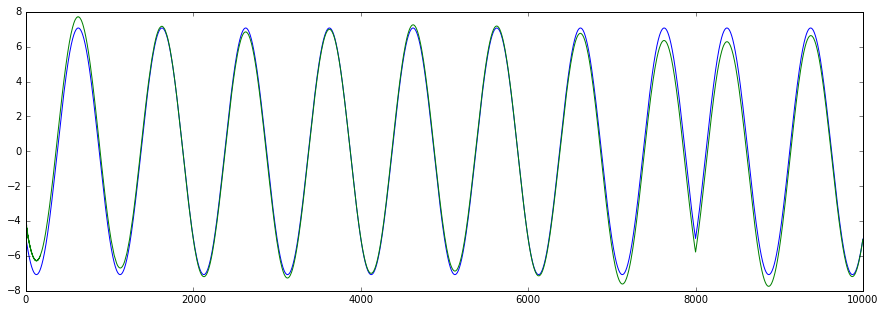

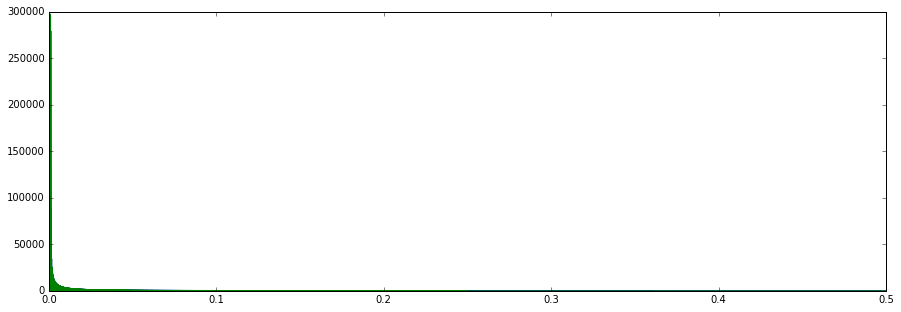

In [2]:
%pylab inline
from matplotlib import rcParams
import matplotlib.pyplot as plt
import numpy as np
from random import randrange
from crypto_chaotic import lorenz_attractor, modulation
from scipy.fftpack import rfft, irfft, fftfreq

nosdata = 10
p = 1000
E = 5
sampling = 4
#########################################
###     Random Signal Generation      ###
#########################################
#signal = np.array([randrange(0, 2**64) for i in range(nosdata)], dtype=np.uint64)
signal = np.array([0x0123456789abcdef, 0x0123456789abcdef], dtype=np.uint64)

#########################################
###          QPSK Modulation          ###
#########################################
modsig = modulation.qpsk_modulate(signal, p = p, sampling = sampling, E=E)

#########################################
###         Frequency Domain          ###
#########################################
W = fftfreq(modsig.size, d=1)
f_signal = rfft(modsig)

#########################################
###              Filter               ###
#########################################
cut_f_signal = f_signal.copy()
cut_f_signal[(W<0.5/p)] = 0

#########################################
###            Time Domain            ###
#########################################
cut_signal = irfft(cut_f_signal)



for i in signal:
    print(bin(i))
#########################################
###        QPSK Demodulation          ###
#########################################
dmodsig = modulation.qpsk_demodulate(cut_signal, p = p, sampling = sampling, E=E)

#########################################
###        Comparing Signals          ###
#########################################
if (signal[-100:] == dmodsig[-100:]).all():
    print('matched')
else:
    print('error') 
    
#########################################
###          Plot Signals             ###
#########################################

modulation.plotamp([modsig, cut_signal], xmin = 0, xmax = 10000)
modulation.drawfft([modsig, cut_signal], xlow=0, xhigh=0, ylow=0, yhigh=0)


In [3]:
%pylab inline
from matplotlib import rcParams
import matplotlib.pyplot as plt
import numpy as np
from random import randrange
from crypto_chaotic import lorenz_attractor, modulation
from scipy.fftpack import rfft, irfft, fftfreq

nosdata = 10
p = 64
E = 0.5
sampling = 20

tstep = 0.01
ndrop = 150
N = 3

#########################################
###     Random Signal Generation      ###
#########################################
signal = np.array([randrange(0, 2**64) for i in range(nosdata)], dtype=np.uint64)
signalbypass = np.zeros(nosdata*32*p*sampling, dtype=np.uint64)

#########################################
###          QPSK Modulation          ###
#########################################
modsig = modulation.qpsk_modulate(signal, p = p, sampling = sampling, E = E)

#########################################
###         Frequency Domain          ###
#########################################
W = fftfreq(modsig.size, d=1)
f_signal = rfft(modsig)

#########################################
###              Filter               ###
#########################################
cut_f_signal = f_signal.copy()
#print (W<0.5/p)
cut_f_signal[(W<0.5/p)] = 0

#########################################
###            Time Domain            ###
#########################################
modsig_cut_signal = irfft(cut_f_signal)

#########################################
###           Chaos Encrypt           ###
#########################################
encryptedx, xt = lorenz_attractor.chaos_encrypt(modsig_cut_signal, N = N, tstep = tstep, ndrop = ndrop) 
#encryptedx, xt = lorenz_attractor.chaos_encrypt(signalbypass, N = N, tstep = tstep, ndrop = ndrop)  


Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [4]:

#########################################
###           Chaos Decrypt           ###
#########################################
recovered, xr = lorenz_attractor.chaos_decrypt(encryptedx, N = N, tstep = tstep, ndrop = ndrop)

#########################################
###         Frequency Domain          ###
#########################################
W = fftfreq(recovered.size, d=1)
f_signal = rfft(recovered)

#########################################
###              Filter               ###
#########################################
cut_f_signal = f_signal.copy()
#print (W<0.5/p)
#cut_f_signal[(W<1/p)] = 0
#cut_f_signal[(W>0/p)] = 0
cut_f_signal[(W>0.04)] = 0
cut_f_signal[(W<0.025)] = 0
#print 0.9/p, 0.5/p

#########################################
###            Time Domain            ###
#########################################
recovered_cut_signal = irfft(cut_f_signal)

#########################################
###        QPSK Demodulation          ###
#########################################
dmodsig = modulation.qpsk_demodulate(recovered_cut_signal, p = p, sampling = sampling, E = E)

#########################################
###        Comparing Signals          ###
#########################################
if (signal == dmodsig).all():
    print ('matched')
else:
    print ('error')    
print (signal == dmodsig)

matched
[ True  True  True  True  True  True  True  True  True  True]


-1000 -1


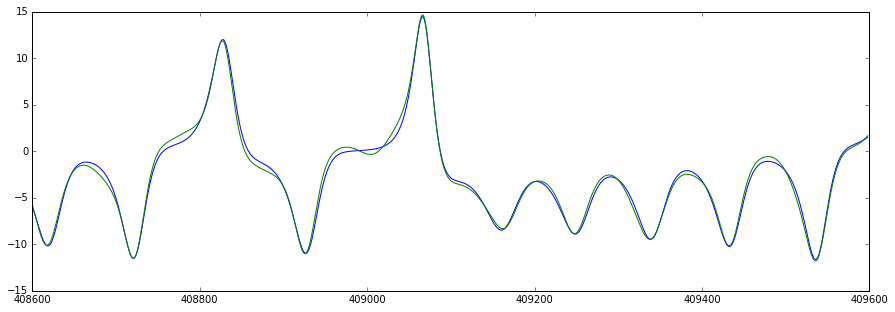

-1000 -1


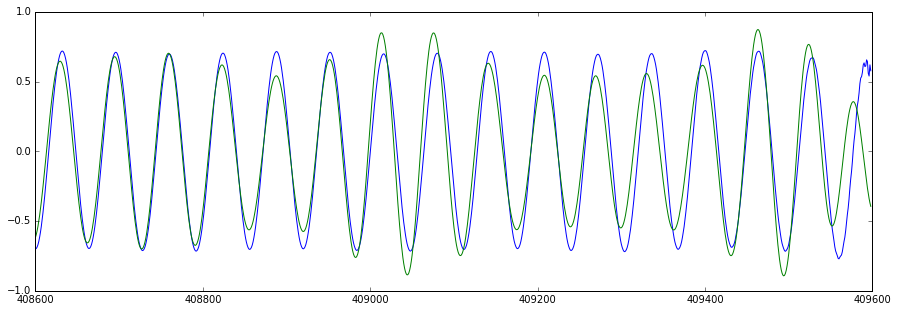

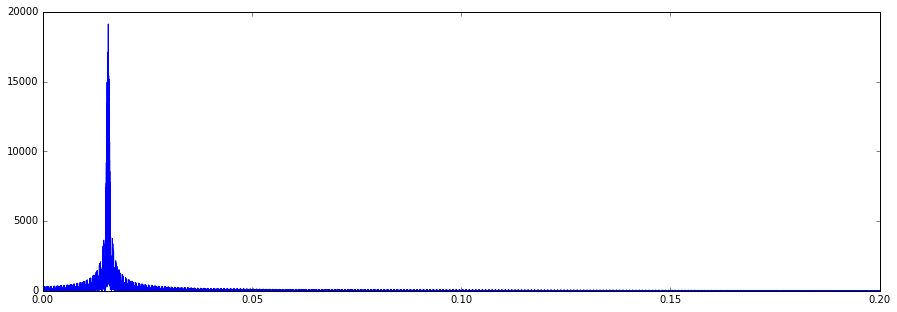

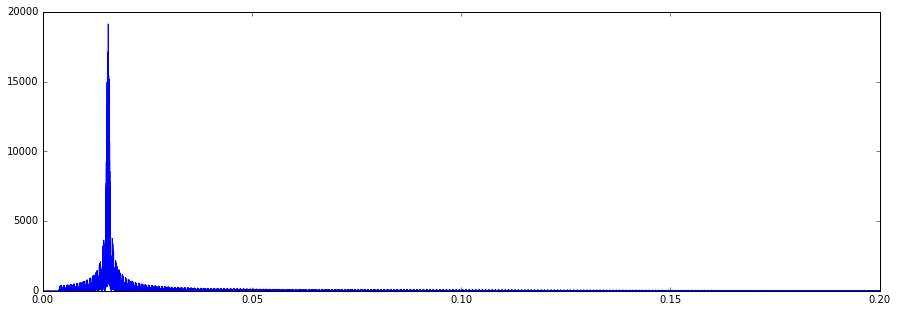

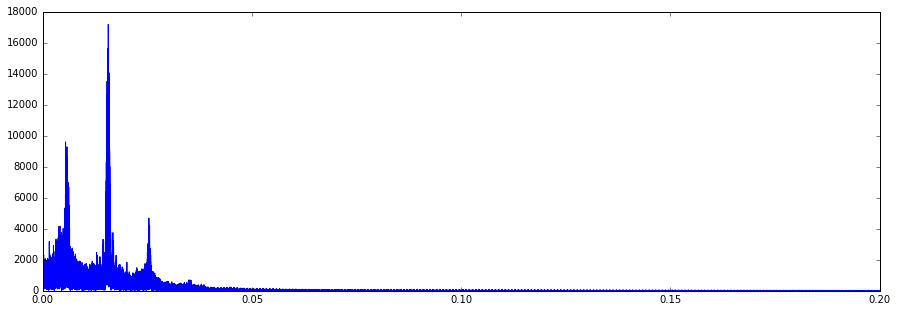

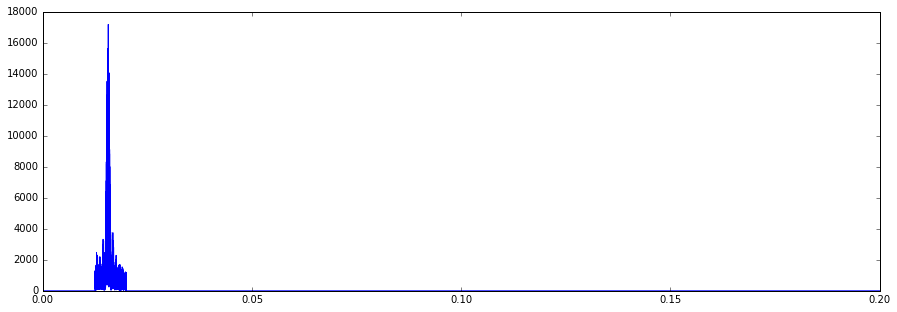

In [5]:
#########################################
###          Plot Signals             ###
#########################################
modulation.plotamp([xt, xr], xmin = -1000, xmax = -1)
modulation.plotamp([modsig_cut_signal, 
                   # recovered, 
                    recovered_cut_signal
                   ], xmin = -1000, xmax = -1)
modulation.drawfft([modsig, 
                    #modsig_cut_signal, 
                    #recovered_cut_signal
                   ], xlow=0, xhigh=0.2, ylow=0, yhigh=0)
modulation.drawfft([modsig_cut_signal, 
                    #recovered_cut_signal
                   ], xlow=0, xhigh=0.2, ylow=0, yhigh=0)
modulation.drawfft([recovered
                   ], xlow=0, xhigh=0.2, ylow=0, yhigh=0)
modulation.drawfft([recovered_cut_signal
                   ], xlow=0, xhigh=0.2, ylow=0, yhigh=0)

In [6]:
if (signal[-10:] == dmodsig[-10:]).all():
    print ('matched')
else:
    print ('error')
print (signal[-10:], dmodsig[-10:])
print (signal[-10:] == dmodsig[-10:])

matched
(array([ 2720751368930399706, 9224488124409165628, 12348303870354003010,
       14168126284346742929, 9526529728493693835,  6971393259357815402,
         204180065198521143,  8664709556555871081, 17891765472868975843,
        5621526225520601343], dtype=uint64), array([ 2720751368930399706, 9224488124409165628, 12348303870354003010,
       14168126284346742929, 9526529728493693835,  6971393259357815402,
         204180065198521143,  8664709556555871081, 17891765472868975843,
        5621526225520601343], dtype=uint64))
[ True  True  True  True  True  True  True  True  True  True]


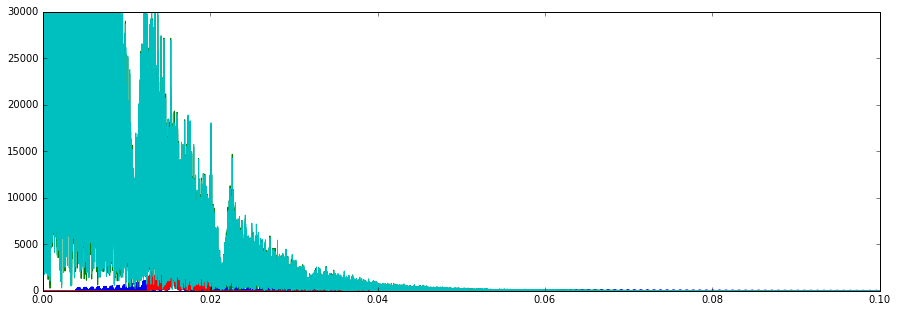

In [7]:
modulation.drawfft([modsig_cut_signal, xt, 
                    recovered_cut_signal, xr
                   ], xlow=0, xhigh=0.1, ylow=0, yhigh=30000)